<center>
 <h1> INF395 - Introducción a las Redes Neuronales Artificiales</h1>
    <h2> Tarea 0</h2>
</center>
<b>Integrantes:</b>
* Camilo Saldías González - 201223512-K - camilo.saldias.12@sansano.usm.cl
* Felipe Vásquez Astudillo - 201473504-9 - felipe.vasquez.14@sansano.usm.cl

# Tabla de contenido
* [1.-Back-propagation (BP) from *Scratch*](#p1)
* [2.-Comparar back-propagation (BP) de Keras](#p2)
* [3.-Verificación numérica del gradiente para una componente](#p3)
* [4.-Implementar momentum como variante](#p4)

<div id='p1' />
## 1. Back-propagation (BP) from *Scratch*

Primero, se importan los paquetes relevantes.

In [58]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from timeit import default_timer as timer

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14.0, 12.0)
np.set_printoptions(suppress=True)

Variables de inicialización son definidas, para establecer el número de neuronas, dimension del input, del output y constantes de aprendizaje.

In [8]:
nn_input_dim = 4 # Dimensionalidad de capa de entrada
nn_output_dim = 3 # Dimensionalidad de capa de salida
nn_hidden1_dim = 32 #Dimensionalidad de capa 1
nn_hidden2_dim = 16 #Dimensionalidad de capa 2
epsilon = 0.01 # Tasa de aprendizaje de la red

Dado que hay que calcular el costo por cada iteración de la red neuronal, es necesario definir una función que reciba como parámetro el estado actual de la red.

In [27]:
def calculate_loss_cco(model, X, y, act_function):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    in1 = X.dot(W1) + b1
    out1 = ReLU(in1) if act_function == 'relu' else Sigmoid(in1) #ReLU o Sigmoid
    in2 = out1.dot(W2) + b2
    out2 = ReLU(in2) if act_function == 'relu' else Sigmoid(in2) #ReLU o Sigmoid
    in3 = out2.dot(W3) + b3
    exp_scores = np.exp(in3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #softmax
    
    corect_logprobs = -1.0 * y * np.log(probs)
    data_loss = np.sum(corect_logprobs)
    return 1./X.shape[0] * data_loss

In [28]:
def calculate_loss_mse(model, X, y, act_function):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    in1 = X.dot(W1) + b1
    out1 = ReLU(in1) if act_function == 'relu' else Sigmoid(in1) #ReLU o Sigmoid
    in2 = out1.dot(W2) + b2
    out2 = ReLU(in2) if act_function == 'relu' else Sigmoid(in2) #ReLU o Sigmoid
    in3 = out2.dot(W3) + b3
    exp_scores = np.exp(in3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #softmax
    
    corect_logprobs = np.square(y - probs)
    data_loss = np.sum(corect_logprobs)
    
    return 1./X.shape[0] * data_loss

Dado que el método SGD requiere que se trabaje con un orden aleatorio del set de entrenamiento, creamos una función que se encargue de entregar el set de entrenamiento en un orden aleatorio.

In [29]:
def shuffle_dataset(X, y):
    combined_dataset = np.concatenate((X_train, y_onehot), axis=1)
    np.random.shuffle(combined_dataset)
    x_shuffled, y_shuffled = np.hsplit(combined_dataset, [4])
    return (x_shuffled, y_shuffled)

La siguiente función también evalúa la red neuronal, pero en lugar de calcular el costo, obtiene los puntajes de clasificación y retorna las probabilidades asociadas.

In [69]:
def predict(model, X, act_function):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    in1 = X.dot(W1) + b1
    out1 = ReLU(in1) if act_function == 'relu' else Sigmoid(in1) #ReLU o Sigmoid
    in2 = out1.dot(W2) + b2
    out2 = ReLU(in2) if act_function == 'relu' else Sigmoid(in2) #ReLU o Sigmoid
    in3 = out2.dot(W3) + b3
    exp_scores = np.exp(in3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #Softmax
    return probs

Funciones de activación a utilizar son definidas, es decir la logística y ReLU, al igual que sus respectivas derivadas.

In [63]:
def ReLU(val):
    return np.maximum(0, val)
def BP_ReLU(val):
    return (val > 0).astype(int)

In [64]:
def Sigmoid(val):
    return 1.0 / (1.0 + np.exp(-1.0 * val))
def BP_Sigmoid(val):
    return (1 - Sigmoid(val)) * Sigmoid(val)

Por último, a continuación se presenta la rutina principal, que hace uso de las funciones anteriores e itera un número definido de veces.

In [33]:
# - num_epoch: Numero de ciclos (epochs) para entrenamiento de la red
# - print_loss: Logear los datos de error de clasificación y función de pérdida
# - loss_function: Seleccionar la función de pérdida a utilizar
#                  Categorical Cross-Entropy (cco) o Mean Squared Error (mse)
# - act_function: Seleccionar la función de activación a utilizar
#                 ReLU (relu) or Sigmoid (sigmoid)
def build_model(X, y, num_epoch=200, print_loss=False, loss_function = "cco", act_function = "relu"):
    
    # Inicializar los parámetros de la red a valores aleatorios.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hidden1_dim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hidden1_dim))
    W2 = np.random.randn(nn_hidden1_dim, nn_hidden2_dim) / np.sqrt(nn_hidden1_dim)
    b2 = np.zeros((1, nn_hidden2_dim))
    W3 = np.random.randn(nn_hidden2_dim, nn_output_dim) / np.sqrt(nn_hidden2_dim)
    b3 = np.zeros((1, nn_output_dim))

    # Esto es lo que retornaremos al final.
    model = {}
    it_data = []
    
    # Usamos SGD para el entrenamiento. Para cada epoch...
    for i in range(0, num_epoch):
        # Reordenamos aleatoriamente el dataset
        x_shuffled, y_shuffled = shuffle_dataset(X, y)
        
        epoch_loss = []
        correct_guesses = 0
        
        #...E iteramos sobre cada ejemplo, 1 a la vez
        for j in range(x_shuffled.shape[0]):
            x_example = x_shuffled[j].reshape((1,4)) #reshape() para que sea tratada como "matriz"
            y_example = y_shuffled[j]                #y no como un vector ((4,1) en lugar de (4,))
            
            # Feed-Forward
            in1 = x_example.dot(W1) + b1
            out1 = ReLU(in1) if act_function == 'relu' else Sigmoid(in1) #ReLU o Sigmoid
            in2 = out1.dot(W2) + b2
            out2 = ReLU(in2) if act_function == 'relu' else Sigmoid(in2) #ReLU o Sigmoid
            in3 = out2.dot(W3) + b3
            exp_scores = np.exp(in3)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) #Softmax

            # Back-Propagation
            delta4 = probs - y_example
            dW3 = np.dot(out2.T, delta4)
            db3 = np.sum(delta4, axis=0, keepdims=True)
            delta3 = delta4.dot(W3.T) * (BP_ReLU(out2) if act_function == 'relu' else BP_Sigmoid(out2)) #ReLU o Sigmoid
            dW2 = np.dot(out1.T, delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(W2.T) * (BP_ReLU(out1) if act_function == 'relu' else BP_Sigmoid(out1)) #ReLU o Sigmoid
            dW1 = np.dot(x_example.T, delta2)
            db1 = np.sum(delta2, axis=0)

            # Asignamos los parámetros del modelo hasta el momento, antes de aplicar SGD
            model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

            #Cálculo del error (CCO or MSE)
            loss = calculate_loss_cco(model, x_example, y_example, act_function) if loss_function == 'cco' else calculate_loss_mse(model, x_example, y_example, act_function)
            epoch_loss.append(loss)
            
            #Error de clasificación (): número de predicciones correctas / número de ejemplos
            if np.argmax(probs) == np.argmax(y_example): correct_guesses += 1
                        
            #Actualizamos los parámetros de nuestra red
            W1 += -epsilon * dW1 * loss
            b1 += -epsilon * db1 * loss
            W2 += -epsilon * dW2 * loss
            b2 += -epsilon * db2 * loss
            W3 += -epsilon * dW3 * loss
            b3 += -epsilon * db3 * loss

            # Asignamos los parámetros del modelo luego de ser actualizados
            model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
        
        # Opcionalmente, logeamos error (loss) y error de clasificación (accuracy)
        if print_loss:
            total_loss = np.average(epoch_loss)
            total_accuracy = correct_guesses / x_shuffled.shape[0]
            it_data.append( (i, total_loss, total_accuracy) )
    
    return (model, it_data)

De la librería **sklearn** se obtiene el set de datos a evaluar.

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
X_train,y_train = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
#transform target to one hot vector
import keras
y_onehot = keras.utils.to_categorical(y_train)
num_examples = len(X_train)

Con las funciones anteriores, se procede a generar el modelo de la red neuronal y luego se evalúa el set de datos para un número determinado de iteraciones.

Este proceso es ilustrado en un gráfico de pérdida en función de las iteraciones, para cada una de las posibles combinaciones de función de error / función de activación.

Tiempo de ejecución para CCO/ReLU: 5.039445997681469 seg
Tiempo de ejecución para CCO/Sigmoid: 6.1112396898679435 seg
Tiempo de ejecución para MSE/ReLU: 4.970167500898242 seg
Tiempo de ejecución para MSE/Sigmoid: 6.05191065184772 seg


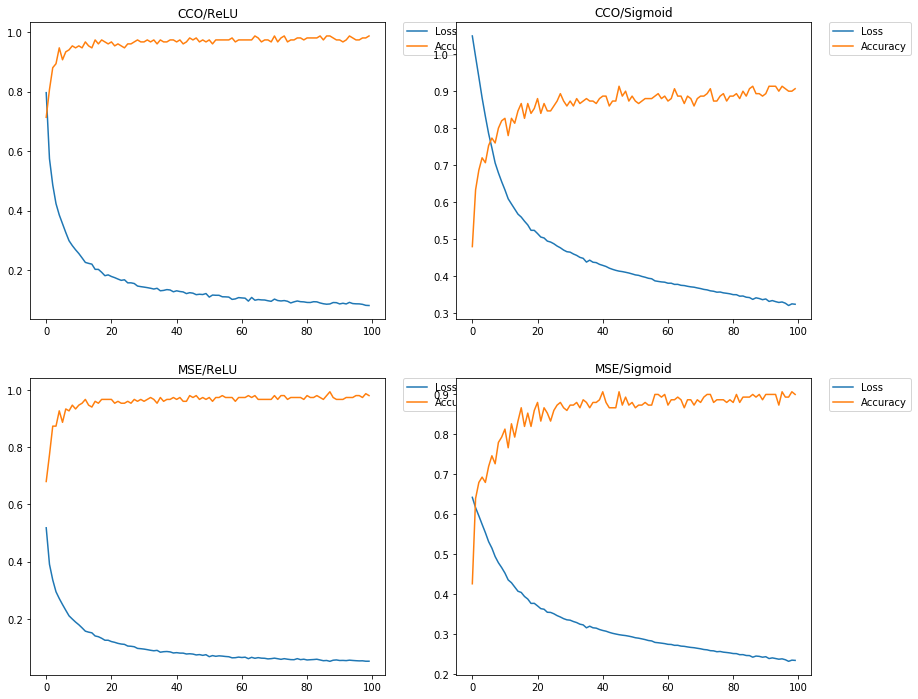

In [60]:
# Modelo 1: CCO / ReLU
start = timer()
model_1, iteration_data_1 = build_model(X_train, y_onehot.astype(int), 100, True, "cco", "relu")
end = timer()
epoch_1, loss_1, accuracy_1 = zip(*iteration_data_1)
print("Tiempo de ejecución para CCO/ReLU: {} seg".format(end - start))

#Modelo 2: CCO / Sigmoid
start = timer()
model_2, iteration_data_2 = build_model(X_train, y_onehot.astype(int), 100, True, "cco", "sigmoid")
end = timer()
epoch_2, loss_2, accuracy_2 = zip(*iteration_data_2)
print("Tiempo de ejecución para CCO/Sigmoid: {} seg".format(end - start))

#Modelo 3: MSE / ReLU
start = timer()
model_3, iteration_data_3 = build_model(X_train, y_onehot.astype(int), 100, True, "mse", "relu")
end = timer()
epoch_3, loss_3, accuracy_3 = zip(*iteration_data_3)
print("Tiempo de ejecución para MSE/ReLU: {} seg".format(end - start))

#Modelo 2: MSE / Sigmoid
start = timer()
model_4, iteration_data_4 = build_model(X_train, y_onehot.astype(int), 100, True, "mse", "sigmoid")
end = timer()
epoch_4, loss_4, accuracy_4 = zip(*iteration_data_4)
print("Tiempo de ejecución para MSE/Sigmoid: {} seg".format(end - start))

plt.subplot(221)
plt.plot(epoch_1, loss_1, label="Loss")
plt.plot(epoch_1, accuracy_1, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_title('CCO/ReLU')
plt.subplot(222)
plt.plot(epoch_2, loss_2, label="Loss")
plt.plot(epoch_2, accuracy_2, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_title('CCO/Sigmoid')
plt.subplot(223)
plt.plot(epoch_3, loss_3, label="Loss")
plt.plot(epoch_3, accuracy_3, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_title('MSE/ReLU')
plt.subplot(224)
plt.plot(epoch_4, loss_4, label="Loss")
plt.plot(epoch_4, accuracy_4, label="Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_title('MSE/Sigmoid')
plt.show()

Finalmente, para la configuración CCO/ReLU, creamos la matriz de confusión utilizando la librería *sklearn*:

In [77]:
y_predicted = predict(model_1, X_train, "relu")
sklearn.metrics.confusion_matrix(y_train, np.argmax(y_predicted, axis=1))

array([[50,  0,  0],
       [ 0, 46,  4],
       [ 0,  0, 50]])

<div id='p2' />
## 2.- Comparar back-propagation (BP) de Keras



Se procede a generar el modelo utilizando los pasos indicados por el enunciado. En primera instancia, se utiliza el modelo con función de costo _categorical cross-entropy_.

In [45]:
from keras.models import Sequential
from keras.layers.core import Dense
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation="sigmoid"))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(3, activation="softmax"))

In [46]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.1),loss="categorical_crossentropy", metrics=["accuracy"])

Se entrena el modelo, guardando la información de las iteraciones.

In [47]:
history=model.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)

Luego son comparados ambos modelos, el compilado en la primera pregunta y el recién generado.

[]

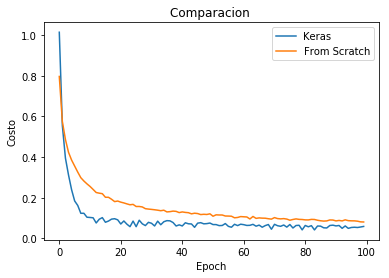

In [48]:
linea1,=plt.plot(epoch,history.history["loss"],label='Keras')
linea2,=plt.plot(epoch,loss,label='From Scratch')
plt.xlabel("Epoch")
plt.ylabel("Costo")
plt.title("Comparacion ")
plt.legend(handles=[linea1,linea2])
plt.plot()

Lo mismo se repite para la función de pérdida _Mean Squared Error_.

In [49]:
model2 = Sequential()
model2.add(Dense(32, input_dim=X_train.shape[1], activation="sigmoid"))
model2.add(Dense(16, activation="sigmoid"))
model2.add(Dense(3, activation="softmax"))
model2.compile(optimizer=SGD(lr=0.1),loss="mse", metrics=["accuracy"])
history=model2.fit(X_train, y_onehot, epochs=100, batch_size=1, verbose=0)

Entonces se grafican los resultados.

[]

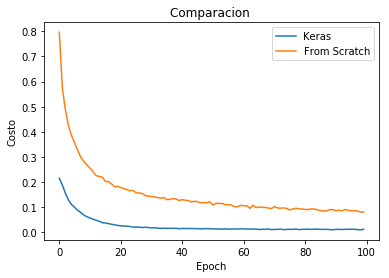

In [50]:
linea1,=plt.plot(epoch,history.history["loss"],label='Keras')
linea2,=plt.plot(epoch,loss,label='From Scratch')
plt.xlabel("Epoch")
plt.ylabel("Costo")
plt.title("Comparacion ")
plt.legend(handles=[linea1,linea2])
plt.plot()

<div id='p3' />
# 3.- Verificación numérica del gradiente para una componente

Primero se geneneran dos números aleatorios, el primero correspondiente a la neurona de la capa de entrada, y el segundo a la neurona del primer nivel escondido.

In [52]:
inputRand=np.random.randint(4)
pesoRand=np.random.randint(32)
print(inputRand,pesoRand)

2 28


El valor para un peso entre la primera y segunda capa buscado es: 
$$\frac{ \partial Loss}{\partial w_1}$$ 

Este es calculado en el paso de backpropagation, denotado por la llave _dW1_ en la variable _grad_, conteniendo la gradiente.

In [53]:
print(grad["dW1"][inputRand][pesoRand])

NameError: name 'grad' is not defined

In [54]:
print(modelo["W1"][inputRand][pesoRand])
epsilon=10**-6
peso=modelo["W1"][inputRand][pesoRand]
#Funcion de costo???
#print((func(peso+epsilon)-func(peso))/epsilon)

NameError: name 'modelo' is not defined

In [60]:
calculate_loss(modelo,X_train, y_onehot.astype(int))

0.28531837863884435

In [61]:
modelo_prima={ 'W1': modelo["W1"]+epsilon, 'b1': modelo["b1"], 'W2': modelo["W2"]+epsilon, 'b2': modelo["b2"], 'W3': modelo["W3"]+epsilon, 'b3': modelo["b3"]}

In [62]:
(calculate_loss(modelo_prima,X_train, y_onehot.astype(int))-calculate_loss(modelo,X_train, y_onehot.astype(int)))/epsilon

-1.996311060792344

<div id='p4' />
# 4.- Implementar momentum como variante